In [1]:
import get_data
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from get_data import get_coindata
from get_data import create_rnndata#BTC_days_T30
from get_data import get_xpred
import pickle 

In [2]:
def scalerX(x_data):
    x_scaler_mean = [] 
    x_scaler_std = []
    #정규분포 변환
    #z = (x - u) / s
    import numpy as np
    x_data = x_data.astype(np.float64)
    for i in range(len(x_data[0][0])):#각 필드 정규분포 변환
        xm = x_data[:,:,i].mean()
        xs = x_data[:,:,i].std()
        x_data[:,:,i] = (x_data[:,:,i]-xm)/xs
        x_scaler_mean.append(xm)
        x_scaler_std.append(xs)
    with open("BTC_days.pic","wb") as fp:
        pickle.dump({"x_scaler_mean":x_scaler_mean,"x_scaler_std":x_scaler_std},fp)
    return x_data
def pred_scaler(x_data):
    with open("BTC_days.pic","rb") as fp:
        scdata = pickle.load(fp)
        x_scaler_mean = scdata["x_scaler_mean"]
        x_scaler_std = scdata["x_scaler_std"]
        print(x_scaler_mean)
        print(x_scaler_std)
    x_data = x_data.astype(np.float64)
    for i in range(len(x_data[0][0])):#각 필드 정규분포 변환
        x_data[:,:,i] = (x_data[:,:,i]-x_scaler_mean[i])/x_scaler_std[i]
    return x_data


In [3]:
#데이터 수신 및 생성
rawdata = get_coindata("btc",to="2016-03-02 23:59:00")
x_data,y_data=create_rnndata(rawdata)
print(x_data.shape,y_data.shape)
x_data = scalerX(x_data)
print(x_data[0][0])

(3370, 30, 5) (3370,)
[-0.89625095 -0.8989988  -0.89453905 -0.89644238 -0.89625415]


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense, ConvLSTM1D, Bidirectional,Reshape, GlobalAveragePooling1D,Dropout,GlobalMaxPool1D,AveragePooling1D,Flatten,MaxPooling1D
tf.random.set_seed(123)
np.random.seed(123)
model = Sequential()
model.add(Input((30,5)))# 30은 문장의 길이, 5 단어 임베딩
model.add(Reshape((30,5,1)))
conv_lstm1 = ConvLSTM1D(
    16,
    3,
    strides=1,
    padding='same',
    dropout=0.3,
    recurrent_dropout=0.5,
    return_sequences=True)
conv_lstm2 = ConvLSTM1D(
    32,
    5,
    strides=2,
    padding='same',
    dropout=0.4,
    recurrent_dropout=0.4,
    return_sequences=False)
model.add(Bidirectional(conv_lstm1))
model.add(Bidirectional(conv_lstm2))
# model.add(conv_lstm1)
# model.add(conv_lstm2)
model.add(AveragePooling1D())
model.add(Flatten())
model.add(Dropout(0.4,seed=123))
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.4,seed=123))
model.add(Dense(1,activation="linear"))
adam = tf.keras.optimizers.Adam(learning_rate=0.00009)
model.compile(loss="mse",optimizer=adam,metrics = ["mae"])


In [5]:
print(x_data.shape,y_data.shape)

(3370, 30, 5) (3370,)


In [6]:
filepath = "{epoch:02d}-{val_loss:.2f}.keras"
mck = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='auto',
    save_freq='epoch')
#callbacks=[mck],
y_data= y_data/100000000.
fhist = model.fit(x_data,y_data,validation_split=0.2,epochs=15,batch_size=len(x_data)//10)

Epoch 1/15
8/8 [==============================] - 20s 1s/step - loss: 0.0800 - mae: 0.2065 - val_loss: 0.6880 - val_mae: 0.7628
Epoch 2/15
8/8 [==============================] - 11s 1s/step - loss: 0.0669 - mae: 0.1905 - val_loss: 0.4990 - val_mae: 0.6516
Epoch 3/15
8/8 [==============================] - 15s 2s/step - loss: 0.0552 - mae: 0.1755 - val_loss: 0.3518 - val_mae: 0.5470
Epoch 4/15
8/8 [==============================] - 14s 2s/step - loss: 0.0443 - mae: 0.1572 - val_loss: 0.2275 - val_mae: 0.4367
Epoch 5/15
8/8 [==============================] - 14s 2s/step - loss: 0.0342 - mae: 0.1391 - val_loss: 0.1296 - val_mae: 0.3211
Epoch 6/15
8/8 [==============================] - 14s 2s/step - loss: 0.0331 - mae: 0.1349 - val_loss: 0.0771 - val_mae: 0.2339
Epoch 7/15
8/8 [==============================] - 12s 1s/step - loss: 0.0316 - mae: 0.1309 - val_loss: 0.0492 - val_mae: 0.1726
Epoch 8/15
8/8 [==============================] - 12s 1s/step - loss: 0.0278 - mae: 0.1227 - val_loss: 0

Text(0.5, 1.0, 'MAE')

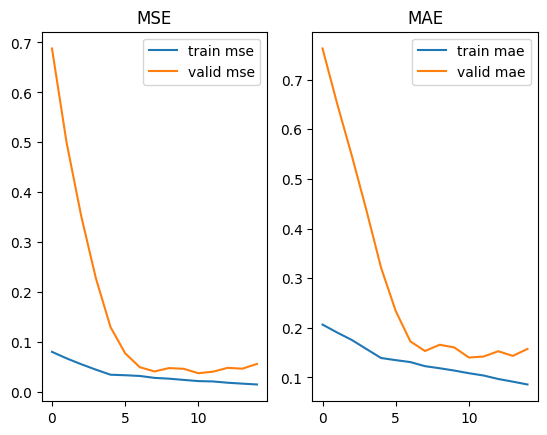

In [7]:
plt.subplot(1,2,1)
plt.plot(fhist.history["loss"],label="train mse")
plt.plot(fhist.history["val_loss"],label="valid mse")
plt.legend()
plt.title("MSE")
plt.subplot(1,2,2)
plt.plot(fhist.history["mae"],label="train mae")
plt.plot(fhist.history["val_mae"],label="valid mae")
plt.legend()
plt.title("MAE")


106/106 [==============================] - 4s 27ms/step


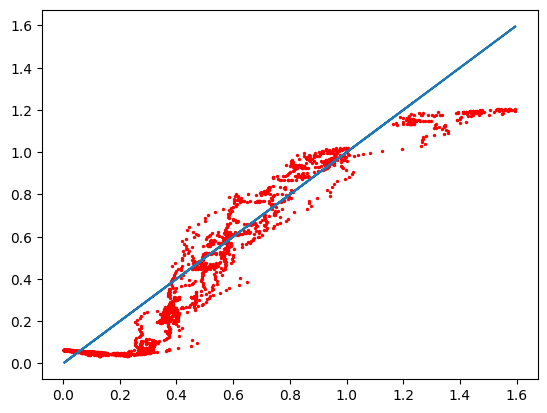

In [8]:
model = tf.keras.models.load_model("BTC_days_T30.keras")
#예측값 
y_pred = model.predict(x_data)
plt .scatter(y_data,y_pred,label="pred _ acc",s=2,color="red")
plt .plot(y_data,y_data, label="true _ acc")
plt.show()

In [10]:
#BTC_days_T30

model = tf.keras.models.load_model("BTC_days_T30.keras")
x_today,x_yesday,y_curprice = get_xpred(coinname="BTC",getunit="days",timm="",timestep=30)
x_today=pred_scaler(np.array([x_today]))
x_yesday=pred_scaler(np.array([x_yesday]))
print(x_today.shape)
print(x_yesday.shape)


ValueError: too many values to unpack (expected 3)

In [11]:
y_yes_pred = model.predict(x_yesday)
y_tod_pred = model.predict(x_today)
print("현재가격:",y_curprice,"현재예측가격:",y_yes_pred[0][0]*100000000, " 오차율:",(1-int(abs(y_yes_pred[0][0]*100000000/y_curprice)*100)/100)*100,"%")
print("예측가격:",y_tod_pred[0][0]*100000000)

NameError: name 'x_yesday' is not defined